In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/blood-transfusion/transfusion.data')

In [4]:
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X, y = df.iloc[:,0:np.shape(df)[1]-1].values, df.iloc[:,np.shape(df)[1]-1].values
X_train , X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3315, random_state = 0)
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)
print "Number of Standardized Training and Test Sets are: \n Training Set: {0} and Testing Set: {1}".format(len(X_train_std), len(X_test_std))

Number of Standardized Training and Test Sets are: 
 Training Set: 500 and Testing Set: 248


/Users/abhishekgupta/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/abhishekgupta/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)


In [5]:
#PCA Demonstration
class PCA(object):
    def __init__(self, verbose = True):
        self.verbose = verbose
    def fit(self, X):
        self.X = X
        cov = np.cov(self.X.T)
        eig_val, eig_vec = np.linalg.eig(cov)
        if self.verbose:
            print "Eigen Values are: %s" % eig_val
            self.variance_explained_ratios(eig_val)
        eig_pair = [(np.abs(eig_val[i]), eig_vec[:,i]) for i in range(len(eig_val))]
        eig_pair.sort(reverse = True)            
        self.w = np.hstack((eig_pair[0][1][:, np.newaxis], eig_pair[1][1][:, np.newaxis]))
        
        return self
    
    def transform(self, X):
        return X.dot(self.w)
        
    def variance_explained_ratios(self, eig_val):
        total = sum(eig_val)
        var_exp = [i/total for i in sorted(eig_val, reverse = True)]
        cm = np.cumsum(var_exp)
        plt.bar(range(1,5), var_exp, align = 'center', label = 'Individual Variance Explained')
        plt.step(range(1,5), cm, where = 'mid', label = 'Cumulative Variance Explianed')
        plt.xlabel('Principal Components')
        plt.ylabel('Explined Variance Ratio')
        plt.legend(loc = 'best')
        plt.show()


Eigen Values are: [  2.55191204e+00   1.08987998e+00   3.66224015e-01   1.39160047e-17]


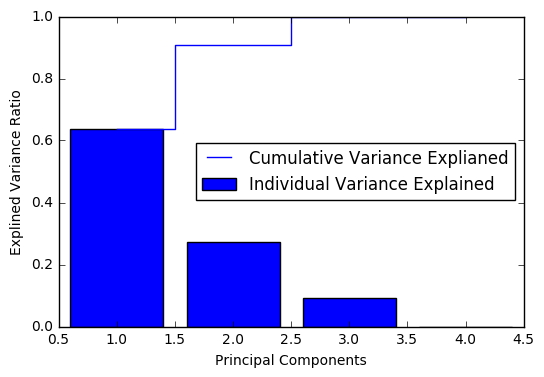

In [6]:
pca = PCA()
pca.fit(X_train_std)
X_train_pca = pca.transform(X_train_std)
X_test_pca = pca.transform(X_test_std)

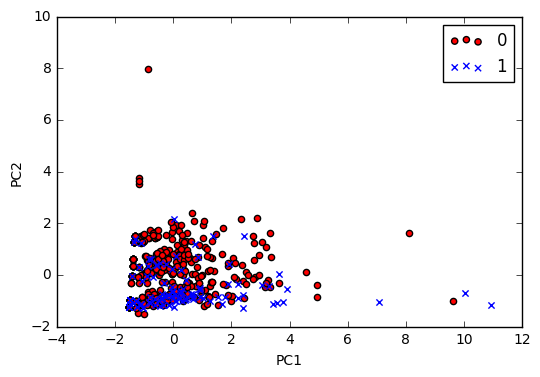

In [7]:
def Show_dataset(X,y):
    labels = np.unique(y)
    color = ['r', 'b']
    markers = ['o', 'x']
    for l, c, m in zip(labels, color, markers):
        plt.scatter(X[y==l, 0], X[y==l, 1], c = c, label = l, marker = m)
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.legend(loc = 'best')
    plt.show()
Show_dataset(X_train_pca, y_train)

In [8]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(X_train_pca, y_train)
print "Training Score: ", lr.score(X_train_pca, y_train)
print "Test Score: ", lr.score(X_test_pca, y_test)

Training Score:  0.788
Test Score:  0.75


In [9]:
from sklearn.neighbors import KNeighborsClassifier as KNC
knn = KNC(n_neighbors = 4)
knn.fit(X_train_pca, y_train)
print "Training Score: ", knn.score(X_train_pca, y_train)
print "Test Score:", knn.score(X_test_pca, y_test)

Training Score:  0.82
Test Score: 0.762096774194


In [10]:
#LDA Demonstration
class LDA(object):
    def __init__(self, verbose = True):
        self.verbose = verbose
    
    def mean_vectors(self, X, y):
        self.mv = []
        for i in np.unique(y):
            self.mv.append(np.mean(X[y==i], axis = 0))
        if self.verbose:
            print [x for x in self.mv]
    
    def Within_class_Scatter_matrix(self, X, y):
        d = len(X[0]) #Number of features
        self.S_W = np.zeros((d, d))
        for label, vec in zip(np.unique(y), self.mv):
            S_i = np.cov(X[y==label].T)
            self.S_W+=S_i
        if self.verbose:
            print('Within-class scatter matrix: %sx%s' % (self.S_W.shape[0], self.S_W.shape[1]))
    
    def Between_class_Scatter_matrix(self, X, y):
        d = len(X[0])
        mean = np.mean(X, axis = 0)
        self.S_B = np.zeros((d,d))
        for idx, val in enumerate(self.mv):
            n = X[y==(idx+1), :].shape[0]
            val = val.reshape(d, 1)
            mean = mean.reshape(d, 1)
            self.S_B += n * (val - mean).dot((val - mean).T)
        if self.verbose:
            print('Between-class scatter matrix: %sx%s' % (self.S_B.shape[0], self.S_B.shape[1]))
    
    def fit(self, X, y):
        self.mean_vectors(X, y)
        self.Within_class_Scatter_matrix(X, y)
        self.Between_class_Scatter_matrix(X, y)
        eig_val, eig_vec = np.linalg.eig(np.linalg.inv(self.S_W).dot(self.S_B))
        eig_pair = [(np.abs(eig_val[i]), eig_vec[:,i]) for i in range(len(eig_val))]
        if self.verbose:
            print 'Eigen Values are: {0}'.format(eig_val)
            self.variance_explained_ratios(eig_val)
        eig_pair = sorted(eig_pair, key=lambda k: k[0], reverse=True)
        self.w = np.hstack((eig_pair[0][1][:, np.newaxis]))
        return self
    
    def transform(self, X):
        return X.dot(self.w)
    
    def variance_explained_ratios(self, eig_val):
        total = sum(eig_val)
        var_exp = [i/total for i in sorted(eig_val, reverse = True)]
        cm = np.cumsum(var_exp)
        plt.bar(range(1,len(eig_val)+1), var_exp, align = 'center', alpha = 0.4, label = 'Individual Discriminability')
        plt.step(range(1,len(eig_val)+1), cm, where = 'mid', label = 'Cumulative Discriminability')
        plt.xlabel('Linear Discriminants')
        plt.ylabel('Discrminability Ratio')
        plt.legend(loc = 'best')
        plt.show()

[array([ 0.14618877, -0.08558281, -0.08558281,  0.03449551]), array([-0.51231919,  0.29992536,  0.29992536, -0.12088967])]
Within-class scatter matrix: 4x4
Between-class scatter matrix: 4x4
Eigen Values are: [  2.01986971e+00 +0.00000000e+00j  -5.03499406e-02 +0.00000000e+00j
   1.39646795e-18 +1.48817074e-09j   1.39646795e-18 -1.48817074e-09j]


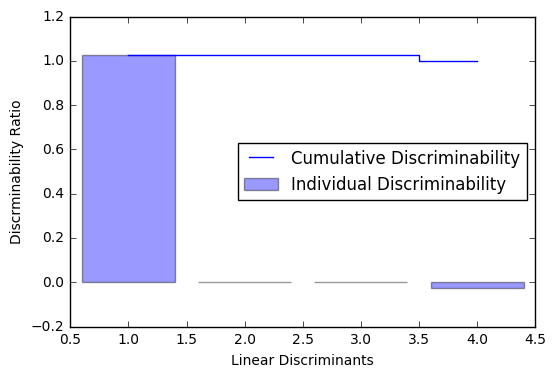

Training Score:  0.82
Test Score: 0.774193548387


In [17]:
lda = LDA()
lda.fit(X_train_std, y_train)
X_train_lda = lda.transform(X_train_std)
X_test_lda = lda.transform(X_test_std)
knn = KNC(n_neighbors = 4)
knn.fit(X_train_lda.reshape(-1,1), y_train)
print "Training Score: ", knn.score(X_train_lda.reshape(-1,1), y_train)
print "Test Score:", knn.score(X_test_lda.reshape(-1,1), y_test)

In [174]:
lr.fit(X_train_lda, y_train)
print "Training Score: ", lr.score(X_train_lda, y_train)
print "Test Score:", lr.score(X_test_lda, y_test)

Training Score:  0.782
Test Score: 0.729838709677
